In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings(action='ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/학교/Dissertation/Data Preprocessing/doc2vec.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

,title,page_id,text,quality,text_pre,doc2vec_20,doc2vec_50,doc2vec_100,doc2vec_150,doc2vec_200
0,Mayan languages,182013,The Mayan languages form a language family spo...,1,mayan language form language family spoken mes...,[ 0.05228575 -0.7528272 -3.2930627 7.81...,[-3.1167188 -0.51315886 -4.0492363 3.337615...,[-2.94301 -0.8504152 -2.0068648 3.494747...,[-1.2495561e+00 -2.6074727e+00 -3.1147242e+00 ...,[-1.0646585 -1.3346218 -3.5811057 6.087087...
1,Mu'awiya I,207068,"Mu'awiya I (Arabic: معاوية بن أبي سفيان, roman...",1,muawiya arabic معاوية بن أبي سفيان romanized m...,[ 1.880606 -4.431403 -2.7955983 -1.829493...,[ 2.180839 -2.1110299 -6.7079535 5.248736...,[ 1.7407136 -0.80208826 -6.6003428 5.100914...,[ 2.150459 -1.2366129 -6.3890724 6.032428...,[ 2.227598 -1.8654984 -6.8027906 5.964404...
2,The Fountainhead,180464,The Fountainhead is a 1943 novel by Russian-Am...,1,fountainhead novel russianamerican author ayn ...,[-1.1044517 -2.747504 -3.3631063 -5.709932...,[-4.2395306 -6.4100766 1.9549298 2.377344...,[-4.329825 -7.180442 1.6074463 2.195198...,[-4.9335074 -7.4910164 0.34299594 2.285627...,[-5.734447 -8.045718 0.11687499 2.710996...
3,Northern pintail,218361,The pintail or northern pintail (Anas acuta) i...,1,pintail northern pintail ana acuta duck specie...,[-1.9572401 1.4564344 -2.165325 6.393158...,[-0.9041298 -0.6752747 -3.3694968 -0.584405...,[-2.6140962e+00 8.9294709e-02 -2.4563761e+00 ...,[-1.4054794 0.1011202 -3.005766 0.243755...,[-1.713172 0.1169865 -4.2138796 0.089964...
4,Manhattan Project,19603,The Manhattan Project was a research and devel...,1,manhattan project research development program...,[ 5.3973994 -3.428697 -5.9390984 0.715733...,[-6.8237815 -3.9645262 3.3373182 1.505026...,[-6.186118 -2.2152514 1.7148697 0.099135...,[-5.779205 -3.8620083 3.9781356 0.464589...,[-7.4099584 -3.9145057 1.6065525 0.999024...
...,...,...,...,...,...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,The Party of Democratic Kampuchea was a politi...,0,party democratic kampuchea political party cam...,[ 0.2985203 0.7032455 -0.03707621 0.138068...,[-1.7322543 0.20272018 -0.98451257 0.647002...,[-1.2276016 -0.07646108 -0.23301132 0.914284...,[-1.2699313 0.07084496 -0.6724753 0.983228...,[-1.7050859 0.38429388 -0.6107001 0.827609...
5196,Minawara and Multultu,95240,"In Aboriginal mythology, Minawara and Multultu...",0,aboriginal mythology minawara multultu legenda...,[-0.05011548 0.33314192 -0.47374865 0.375062...,[-0.7812953 -0.4269692 -0.72439814 -0.089991...,[-0.69870734 -0.33438665 -0.58722293 -0.060399...,[-0.6758598 -0.40375656 -0.60720843 -0.122840...,[-0.8250788 -0.45138186 -0.5446994 -0.074323...
5197,Theophylline/ephedra/hydroxyzine,262652,Theophylline/ephedra/hydroxyzine (trade name M...,0,theophyllineephedrahydroxyzine trade name mara...,[-0.00612844 0.23356082 -0.22676685 0.370103...,[-0.35274357 -0.09349012 -0.23601085 0.043747...,[-0.4175495 -0.09883414 -0.20222571 0.069717...,[-0.31140506 -0.14326145 -0.28372833 0.040355...,[-0.35810485 -0.14381687 -0.19762194 0.083277...
5198,"Channel Lake, Illinois",111450,Channel Lake is an unincorporated community an...,0,channel lake unincorporated community censusde...,[-0.0260246 -0.11023841 -0.6295018 0.426264...,[-0.90208524 -0.48854405 -0.86469644 -0.067525...,[-0.8460111 -0.308263 -0.4235552 -0.042061...,[-0.8384187 -0.43765557 -0.6848947 -0.023144...,[-1.0711137e+00 -5.3657132e-01 -7.0695442e-01 ...


In [ ]:
df = df[['title', 'page_id', 'text_pre', 'quality']]
df

,title,page_id,text_pre,quality
0,Mayan languages,182013,mayan language form language family spoken mes...,1
1,Mu'awiya I,207068,muawiya arabic معاوية بن أبي سفيان romanized m...,1
2,The Fountainhead,180464,fountainhead novel russianamerican author ayn ...,1
3,Northern pintail,218361,pintail northern pintail ana acuta duck specie...,1
4,Manhattan Project,19603,manhattan project research development program...,1
...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,party democratic kampuchea political party cam...,0
5196,Minawara and Multultu,95240,aboriginal mythology minawara multultu legenda...,0
5197,Theophylline/ephedra/hydroxyzine,262652,theophyllineephedrahydroxyzine trade name mara...,0
5198,"Channel Lake, Illinois",111450,channel lake unincorporated community censusde...,0


__Doc2Vec model__
- dm=1: Distributed Memory (DM) model, default
- dm=0: Distributed Bag of Words (DBOW) model

__DM model__
- Continuous Bag of Words (CBOW) model in Word2vec
- context words and document vectors are used to predict a target word

__DBOW model__
- Skip-gram model in Word2vec
- the model predicts context words given a document vector
- Unlike the DM model, the context words themselves are not used to predict the target word. Instead, the model only considers the document vector to predict words randomly sampled from the document.
- this model is simpler and can be trained more quickly since it does not involve averaging or concatenating word vectors


### DM model

In [ ]:
# Preprocess the text (tokenization)
df['doc2vec'] = df['text_pre'].apply(lambda x: word_tokenize(x))

# Create TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['doc2vec'])]

# Train a Doc2Vec model
model = Doc2Vec(documents, vector_size=50, min_count=1, workers=4)

# Infer vectors for each document in the DataFrame
df['doc2vec'] = df['doc2vec'].apply(lambda x: model.infer_vector(x))
df

<ipython-input-5-65a287231821>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['doc2vec'] = df['text_pre'].apply(lambda x: word_tokenize(x))
<ipython-input-5-65a287231821>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['doc2vec'] = df['doc2vec'].apply(lambda x: model.infer_vector(x))


,title,page_id,text_pre,quality,doc2vec
0,Mayan languages,182013,mayan language form language family spoken mes...,1,"[-4.3282576, -0.58440983, -3.6975913, 4.439608..."
1,Mu'awiya I,207068,muawiya arabic معاوية بن أبي سفيان romanized m...,1,"[-0.45835763, -1.645587, -7.571336, 5.8867984,..."
2,The Fountainhead,180464,fountainhead novel russianamerican author ayn ...,1,"[-6.4600163, -7.294761, 1.4258393, 1.1202831, ..."
3,Northern pintail,218361,pintail northern pintail ana acuta duck specie...,1,"[-0.83020604, -0.21964337, -3.7077487, 0.02074..."
4,Manhattan Project,19603,manhattan project research development program...,1,"[-8.766594, -2.032103, 2.386581, -0.46897364, ..."
...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,party democratic kampuchea political party cam...,0,"[-1.9944456, 0.2135615, -0.63443816, 0.6095058..."
5196,Minawara and Multultu,95240,aboriginal mythology minawara multultu legenda...,0,"[-0.7515714, -0.3469127, -0.6677653, -0.031385..."
5197,Theophylline/ephedra/hydroxyzine,262652,theophyllineephedrahydroxyzine trade name mara...,0,"[-0.3019486, -0.09351507, -0.2509725, 0.094247..."
5198,"Channel Lake, Illinois",111450,channel lake unincorporated community censusde...,0,"[-1.0490164, -0.37389216, -0.5354935, 0.016014..."


In [ ]:
def train_and_evaluate_models(X, y, cv=5, test_size=0.2):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Initialize the models
    models = {
        'Logistic Regression': LogisticRegression(),
        'SVM': SVC(),
        'Random Forest': RandomForestClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'XGBoost': XGBClassifier(),
        'MLP': MLPClassifier()
    }

    # Initialize a list to store the results
    results = []

    # Define custom scoring
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted')
    }

    # StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Loop through the models
    for model_name, model in models.items():
        # Perform cross-validation on the training set
        cv_results = {metric: cross_val_score(model, X_train, y_train, cv=skf, scoring=scorer).mean() for metric, scorer in scoring.items()}

        # Train the model on the full training set
        model.fit(X_train, y_train)

        # Predict the test set
        y_pred = model.predict(X_test)

        # Calculate the metrics on the test set
        test_accuracy = accuracy_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred, average='weighted')
        test_recall = recall_score(y_test, y_pred, average='weighted')
        test_f1 = f1_score(y_test, y_pred, average='weighted')

        # Append the results to the list
        results.append({
            'Model': model_name,
            'CV Accuracy': cv_results['accuracy'],
            'CV Precision': cv_results['precision'],
            'CV Recall': cv_results['recall'],
            'CV F1 Score': cv_results['f1'],
            'Test Accuracy': test_accuracy,
            'Test Precision': test_precision,
            'Test Recall': test_recall,
            'Test F1 Score': test_f1
        })

    # Create a dataframe from the results
    results_df = pd.DataFrame(results)

    return results_df

In [ ]:
X = list(df['doc2vec'])
y = df['quality']

In [ ]:
doc2vec = train_and_evaluate_models(X, y)
doc2vec

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score,Test Accuracy,Test Precision,Test Recall,Test F1 Score
0,Logistic Regression,0.804808,0.805405,0.804808,0.804710,0.821154,0.821197,0.821154,0.821148
1,SVM,0.836058,0.838512,0.836058,0.835755,0.843269,0.844494,0.843269,0.843130
2,Random Forest,0.818990,0.829716,0.820913,0.820028,0.824038,0.832510,0.824038,0.822911
3,AdaBoost,0.790144,0.790841,0.790144,0.790014,0.800000,0.800004,0.800000,0.799999
4,XGBoost,0.826683,0.828590,0.826683,0.826420,0.825962,0.827805,0.825962,0.825716
5,MLP,0.816346,0.816987,0.814183,0.811732,0.826923,0.827097,0.826923,0.826900


### SVM

In [ ]:
X = list(df['doc2vec'])
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
model_svm = SVC()
model_svm.fit(X_train,y_train)

SVC()

In [ ]:
def eval(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    print("Test_Set")
    print(classification_report(y_test, y_pred))
    print("Train_Set")
    print(classification_report(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_estimator(model ,X_test, y_test)

Test_Set
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       520
           1       0.82      0.87      0.85       520

    accuracy                           0.84      1040
   macro avg       0.84      0.84      0.84      1040
weighted avg       0.84      0.84      0.84      1040

Train_Set
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2080
           1       0.89      0.93      0.91      2080

    accuracy                           0.90      4160
   macro avg       0.91      0.90      0.90      4160
weighted avg       0.91      0.90      0.90      4160



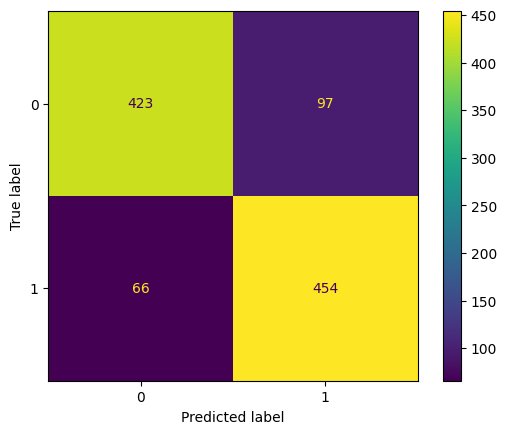

In [ ]:
eval(model_svm, X_train, X_test)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'sigmoid']
}

In [ ]:
model_svm = SVC()
model_svm.fit(X_train,y_train)

SVC()

In [ ]:
grid = GridSearchCV(model_svm, param_grid, cv=5, verbose=3, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=3)

In [ ]:
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Estimator: {grid.best_estimator_}")

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best Estimator: SVC(C=10, gamma=0.01)


In [ ]:
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       520
           1       0.82      0.89      0.85       520

    accuracy                           0.85      1040
   macro avg       0.85      0.85      0.85      1040
weighted avg       0.85      0.85      0.85      1040



- model_svm = SVC(C=10, gamma=0.01)

In [ ]:
X = list(df['doc2vec'])
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
model_svm = SVC(C=10, gamma=0.01)
model_svm.fit(X_train,y_train)

SVC(C=10, gamma=0.01)

Test_Set
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       520
           1       0.82      0.89      0.85       520

    accuracy                           0.85      1040
   macro avg       0.85      0.85      0.85      1040
weighted avg       0.85      0.85      0.85      1040

Train_Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2080
           1       1.00      1.00      1.00      2080

    accuracy                           1.00      4160
   macro avg       1.00      1.00      1.00      4160
weighted avg       1.00      1.00      1.00      4160



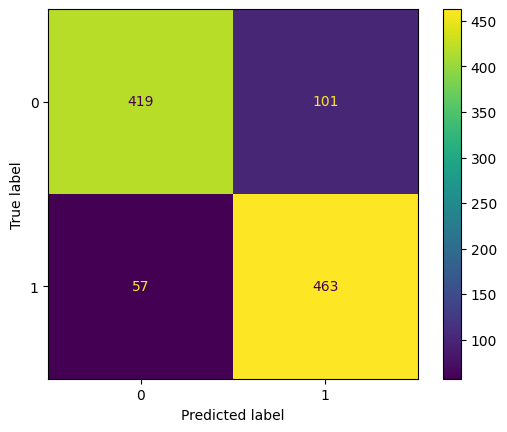

In [ ]:
eval(model_svm, X_train, X_test)

----------

In [ ]:
df

,title,page_id,text_pre,quality,doc2vec,doc2vec2
0,Mayan languages,182013,mayan language form language family spoken mes...,1,"[-4.3282576, -0.58440983, -3.6975913, 4.439608...","[-0.6596773, -0.74979734, -0.6190954, -0.32471..."
1,Mu'awiya I,207068,muawiya arabic معاوية بن أبي سفيان romanized m...,1,"[-0.45835763, -1.645587, -7.571336, 5.8867984,...","[-0.32790035, -0.021798452, -2.2951462, -0.914..."
2,The Fountainhead,180464,fountainhead novel russianamerican author ayn ...,1,"[-6.4600163, -7.294761, 1.4258393, 1.1202831, ...","[-1.1953527, -0.86792094, -0.61884606, 0.96207..."
3,Northern pintail,218361,pintail northern pintail ana acuta duck specie...,1,"[-0.83020604, -0.21964337, -3.7077487, 0.02074...","[-1.6845337, -1.8128366, -0.09468413, 0.697078..."
4,Manhattan Project,19603,manhattan project research development program...,1,"[-8.766594, -2.032103, 2.386581, -0.46897364, ...","[-0.5345133, -0.22011796, -1.3583897, 0.265620..."
...,...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,party democratic kampuchea political party cam...,0,"[-1.9944456, 0.2135615, -0.63443816, 0.6095058...","[-0.6968632, 0.6068616, -1.162947, 0.5849653, ..."
5196,Minawara and Multultu,95240,aboriginal mythology minawara multultu legenda...,0,"[-0.7515714, -0.3469127, -0.6677653, -0.031385...","[-0.53374887, -0.5581892, -0.36888316, -0.2214..."
5197,Theophylline/ephedra/hydroxyzine,262652,theophyllineephedrahydroxyzine trade name mara...,0,"[-0.3019486, -0.09351507, -0.2509725, 0.094247...","[-0.42780882, -0.32363552, -0.32602727, 0.2159..."
5198,"Channel Lake, Illinois",111450,channel lake unincorporated community censusde...,0,"[-1.0490164, -0.37389216, -0.5354935, 0.016014...","[-1.1309028, -0.58181113, -1.0583432, 0.153518..."


In [ ]:
df2 = df[['title', 'page_id', 'doc2vec', 'quality']]

In [ ]:
df2.to_csv('/content/drive/MyDrive/학교/Dissertation/Modelling/doc2vec_50.csv')

### DBOW model

In [ ]:
# Preprocess the text (tokenization)
df['doc2vec2'] = df['text_pre'].apply(lambda x: word_tokenize(x))

# Create TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['doc2vec2'])]

# Train a Doc2Vec model
model = Doc2Vec(documents, vector_size=50, min_count=1, workers=4, dm=0)

# Infer vectors for each document in the DataFrame
df['doc2vec2'] = df['doc2vec2'].apply(lambda x: model.infer_vector(x))
df

,title,page_id,text_pre,quality,doc2vec,doc2vec2
0,Mayan languages,182013,mayan language form language family spoken mes...,1,"[-4.3282576, -0.58440983, -3.6975913, 4.439608...","[-0.6596773, -0.74979734, -0.6190954, -0.32471..."
1,Mu'awiya I,207068,muawiya arabic معاوية بن أبي سفيان romanized m...,1,"[-0.45835763, -1.645587, -7.571336, 5.8867984,...","[-0.32790035, -0.021798452, -2.2951462, -0.914..."
2,The Fountainhead,180464,fountainhead novel russianamerican author ayn ...,1,"[-6.4600163, -7.294761, 1.4258393, 1.1202831, ...","[-1.1953527, -0.86792094, -0.61884606, 0.96207..."
3,Northern pintail,218361,pintail northern pintail ana acuta duck specie...,1,"[-0.83020604, -0.21964337, -3.7077487, 0.02074...","[-1.6845337, -1.8128366, -0.09468413, 0.697078..."
4,Manhattan Project,19603,manhattan project research development program...,1,"[-8.766594, -2.032103, 2.386581, -0.46897364, ...","[-0.5345133, -0.22011796, -1.3583897, 0.265620..."
...,...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,party democratic kampuchea political party cam...,0,"[-1.9944456, 0.2135615, -0.63443816, 0.6095058...","[-0.6968632, 0.6068616, -1.162947, 0.5849653, ..."
5196,Minawara and Multultu,95240,aboriginal mythology minawara multultu legenda...,0,"[-0.7515714, -0.3469127, -0.6677653, -0.031385...","[-0.53374887, -0.5581892, -0.36888316, -0.2214..."
5197,Theophylline/ephedra/hydroxyzine,262652,theophyllineephedrahydroxyzine trade name mara...,0,"[-0.3019486, -0.09351507, -0.2509725, 0.094247...","[-0.42780882, -0.32363552, -0.32602727, 0.2159..."
5198,"Channel Lake, Illinois",111450,channel lake unincorporated community censusde...,0,"[-1.0490164, -0.37389216, -0.5354935, 0.016014...","[-1.1309028, -0.58181113, -1.0583432, 0.153518..."


In [ ]:
X = list(df['doc2vec2'])
y = df['quality']

In [ ]:
doc2vec2 = train_and_evaluate_models(X, y)
doc2vec2

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score,Test Accuracy,Test Precision,Test Recall,Test F1 Score
0,Logistic Regression,0.785577,0.787629,0.785577,0.785198,0.819231,0.820768,0.819231,0.819014
1,SVM,0.821635,0.826176,0.821635,0.821009,0.855769,0.859363,0.855769,0.855408
2,Random Forest,0.802644,0.807656,0.800962,0.794420,0.825962,0.832154,0.825962,0.825147
3,AdaBoost,0.763702,0.764126,0.763702,0.763604,0.787500,0.787527,0.787500,0.787495
4,XGBoost,0.802163,0.804802,0.802163,0.801743,0.828846,0.829548,0.828846,0.828755
5,MLP,0.806010,0.812214,0.814423,0.813565,0.825962,0.826310,0.825962,0.825915


In [ ]:
X = list(df['doc2vec2'])
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
model_svm = SVC()
model_svm.fit(X_train,y_train)

SVC()

Test_Set
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       520
           1       0.82      0.91      0.86       520

    accuracy                           0.86      1040
   macro avg       0.86      0.86      0.86      1040
weighted avg       0.86      0.86      0.86      1040

Train_Set
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      2080
           1       0.86      0.94      0.90      2080

    accuracy                           0.90      4160
   macro avg       0.90      0.90      0.90      4160
weighted avg       0.90      0.90      0.90      4160



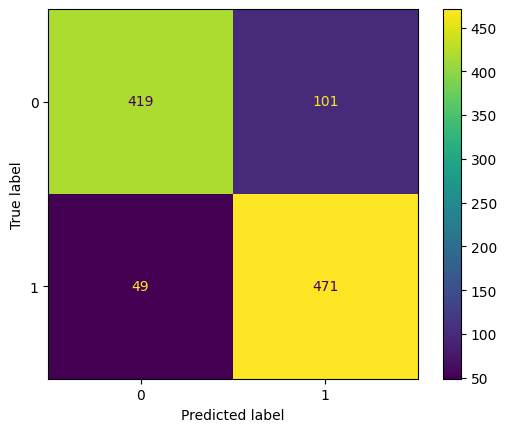

In [ ]:
eval(model_svm, X_train, X_test)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'sigmoid']
}

In [ ]:
model_svm = SVC()
model_svm.fit(X_train,y_train)

SVC()

In [ ]:
grid = GridSearchCV(model_svm, param_grid, cv=5, verbose=3, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=3)

In [ ]:
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Estimator: {grid.best_estimator_}")

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best Estimator: SVC(C=10, gamma=0.01)


In [ ]:
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       520
           1       0.83      0.85      0.84       520

    accuracy                           0.84      1040
   macro avg       0.84      0.84      0.84      1040
weighted avg       0.84      0.84      0.84      1040



In [ ]:
X = list(df['doc2vec2'])
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
model_svm = SVC(C=10, gamma=0.01)
model_svm.fit(X_train,y_train)

SVC(C=10, gamma=0.01)

Test_Set
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       520
           1       0.83      0.85      0.84       520

    accuracy                           0.84      1040
   macro avg       0.84      0.84      0.84      1040
weighted avg       0.84      0.84      0.84      1040

Train_Set
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2080
           1       0.92      0.96      0.94      2080

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



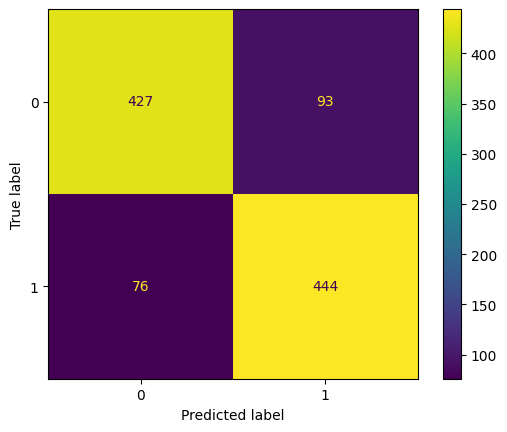

In [ ]:
eval(model_svm, X_train, X_test)